In [2]:
########
#pipe grep command of move sequence into another grep command to get 1-0 to tabulate total wins, ties and losses
#these will need to be incremented in same way as counts

import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import chess.pgn
import chess.engine
import subprocess
import time
import timeit
import pickle
engine = chess.engine.SimpleEngine.popen_uci("./stockfish-10-64")

In [3]:
with open('Lichess2013noNumbers.txt', "r") as file_in:
    mainlineList = []
    for line in file_in:
        mainlineList.append(line)

In [4]:
print(mainlineList[0])

  e4 e6   d4 b6   a3 Bb7   Nc3 Nh6   Bxh6 gxh6   Be2 Qg5   Bg4 h5   Nf3 Qg6   Nh4 Qg5   Bxh5 Qxh4   Qf3 Kd8   Qxf7 Nc6   Qe8# 1-0



In [5]:
stringList = []
for mainLine in mainlineList:
    stringList.append(mainLine.split())
print(len(stringList))

121332


In [6]:
##Testing time taken using grep

# import time
# start = time.process_time()

# command = "grep -I '^ \+e4 d5 \+d4'  Lichess2013noNumbers.txt | wc -l"
# process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
# #Launch the shell command:
# output = process.communicate()
# print(int(re.findall('\d+',str(output))[0]))

# # your code here    
# print(time.process_time() - start)

In [16]:
#make new graph
testSting = 'TEST'
count = 10
g = nx.DiGraph()
g.add_node('fen',score = 100, movelist = {testSting:count})
g.nodes['fen']

{'score': 100, 'movelist': {'TEST': 10}}

In [19]:
test2 = 'TEST2'
nx.get_node_attributes(g, 'movelist')['fen'][test2] = 100
nx.get_node_attributes(g, 'movelist')['fen']

{'TEST': 10, 'TEST2': 100}

In [21]:
'TEST3' in nx.get_node_attributes(g, 'movelist')['fen']

False

In [7]:
print(g.nodes['fen'])
nx.get_node_attributes(g, 'movelist')['fen'] = nx.get_node_attributes(g, 'movelist')['fen'].append(['d'])
g.nodes['fen']['score'] = nx.get_node_attributes(g, 'score')['fen']+100
print(g.nodes['fen'])

{'score': 100, 'movelist': [['a', 'b', 'c']]}
{'score': 200, 'movelist': [['a', 'b', 'c'], ['d']]}


In [8]:
moveString = '^ \+e4'  
print(moveString)
command = "grep -I '{}'  Lichess2013noNumbers.txt | grep -I '[1]$' | wc -l".format(moveString)
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
#Launch the shell command:
output = process.communicate()
print(int(re.findall('\d+',str(output))[0]))

^ \+e4
33320


In [9]:
moveString = '^ \+e4'  
print(moveString)
command = "grep -I '{}'  Lichess2013noNumbers.txt | wc -l".format(moveString)
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
#Launch the shell command:
output = process.communicate()
print(output)
print(int(re.findall('\d+',str(output))[0]))

^ \+e4
(b'   72488\n', None)
72488


In [10]:
# TESTING IF DIFFERENT MOVESTRINGS CONVERGE TO SAME FEN
stringList = [['e4','e5','d4','d5','c3'],
             ['d4','e5','e4','d5','a3']]

In [11]:
start = timeit.default_timer()

g = nx.DiGraph()
g.add_node('', score = 0, movelist = 'root')
X = 10
cnt = 0
for string in stringList:
    if(cnt%100 == 0):
        print("strings processed:", cnt)
    board = chess.Board()
    moveString = '^ \+'
    parentID = ''
    for move in string:
        moveString += move + ' \+'
        try: 
            board.push_san(move) #push the move to the board
            currFen = board.fen() #get the fen from the board
             #BASH SCRIPT TO GET COUNT
            command = "grep -I '{}'  Lichess2013noNumbers.txt | wc -l".format(moveString)
            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
            output = process.communicate()
            count = int(re.findall('\d+',str(output))[0])
        #check if fen exists, if not, do same thing as before
        #if fen does exist, check if movestring exists in list of movestrings, if yes, do nothing (count already gotten)
        # if it doesn't, increment count by count of movestring and add to list of movestrings
            
            #check if fen is new, if yes, and count is high, add new node
            if(currFen not in g.nodes and count>=X): #only add nodes if the sequence has not yet occured and they are frequent enough 
                stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
                g.add_node(currFen, 
                           score = float(str(stockfish['score'])), 
                           count = count,
                           movelist = [[moveString]]) #make a list of moveStrings
                g.add_edge(parentID, currFen)
                parentID = currFen
            #if fen is not new, check if movestring in list of movestrings, if not, add it and add count  
            elif(count>=X):
                if([moveString] not in nx.get_node_attributes(g, 'movelist')[currFen]):
                    nx.get_node_attributes(g, 'movelist')[currFen] = nx.get_node_attributes(g, 'movelist')[currFen].append([moveString])
                    g.nodes[currFen]['count'] = nx.get_node_attributes(g, 'count')[currFen]+count
                    g.add_edge(parentID, currFen)
                parentID = currFen
                g.nodes
            else:
                break
        except: #skip any errors in the notation that cannot be pushed to a board
            print("EXCEPT")
            break
    cnt+=1
stop = timeit.default_timer()
print('Time: ', stop - start)     

strings processed: 0
Time:  3.2034736159999966


In [188]:
#save as pickle
#nx.write_gpickle(g,"TEST.gpickle")

In [10]:
#read pickle
g=nx.read_gpickle("g5000v2.gpickle")
print("totalNodes:",len(g))

totalNodes: 4431


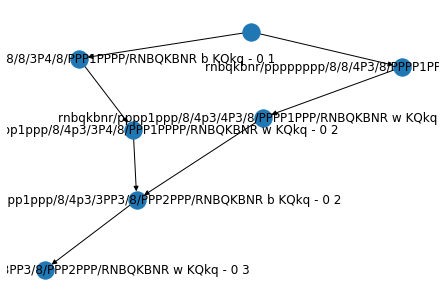

In [35]:
#print("Total Nodes:", len(g))
nx.draw(g, with_labels=True)


In [17]:
def varWeighted(scores, counts):
    weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)

    scoreDiffs = [(score - weightedMean)**2 for score in scores]

    V1 = sum(counts)
    V2 = sum([count**2 for count in counts])
    
    try:
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
    except:
        var = 0
    return var


In [18]:
start = timeit.default_timer()

board = chess.Board()
board.push_san('d4') #push the move to the board
board.push_san('Nf6') #push the move to the board
currFen = board.fen()
scores = []
counts = []
for neighbor in list(g.neighbors(currFen)):
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'count')[neighbor])
    
print("var:",varWeighted(scores, counts))

stop = timeit.default_timer()
print('Time: ', stop - start) 

var: 769.4224254088821
Time:  0.061120164000158184


In [20]:
safe = ['e4', 'c5', 'c3']
risky = ['e4', 'c5', 'd4']

safe2 = ['e4', 'e6', 'd4', 'd5', 'exd5']
risky2 = ['e4', 'e6', 'd4', 'd5', 'e5']
Ruy = ['e4', 'e5','Nf3', 'Nc6','Bb5']
Vienna = ['e4' ,'e5','d4','exd4','c3']
games = [safe,risky,safe2,risky2, Ruy, Vienna]
for game in games:
    board = chess.Board()
    for move in game:
        board.push_san(move)
    currFen = board.fen()
    scores = []
    counts = []
    for neighbor in list(g.neighbors(currFen)):
        scores.append(nx.get_node_attributes(g, 'score')[neighbor])
        counts.append(nx.get_node_attributes(g, 'count')[neighbor])

    print('Var {}:'.format(game), varWeighted(scores,counts), ", total Games:", sum(counts))

Var ['e4', 'c5', 'c3']: 505.60426018934174 , total Games: 342
Var ['e4', 'c5', 'd4']: 5802.094926348421 , total Games: 1270
Var ['e4', 'e6', 'd4', 'd5', 'exd5']: 3361.9999999999995 , total Games: 601
Var ['e4', 'e6', 'd4', 'd5', 'e5']: 8864.217954360909 , total Games: 938
Var ['e4', 'e5', 'Nf3', 'Nc6', 'Bb5']: 475.1226313323931 , total Games: 3306
Var ['e4', 'e5', 'd4', 'exd4', 'c3']: 637.0304632140171 , total Games: 552


In [ ]:
# ###Chess Gambits
# Polish Gambit 1. e4 b5
# Wing Gambit 1. e4 c5 2. b4
# Ware Gambit 1. a4 e5 2. a5 d5 3. e3 f5 4. a6
# Birmingham Gambit 1. b4 c5
# Schuhler Gambit 1. b4 c6 2. Bb2 a5 3. b5 cxb5 4. e4
# Wolferts Gambit 1. b4 e5 2. Bb2 c5
# Englund Gambit 1. d4 e5
# Budapest Gambit 1. d4 Nf6 2. c4 e5
# Benko Gambit 1. d4 Nf6 2. c4 c5 3. d5 b5
# Staunton Gambit 1. d4 f5 2. e4
# Smith-Morra Gambit 1. e4 c5 2. d4 cxd4 3. c3
# Danish Gambit 1. e4 e5 2. d4 exd4 3. c3
# Vienna Gambit 1. e4 e5 2. Nc3 Nf6 3. f4
# King's Gambit 1. e4 e5 2. f4
# Quaade Gambit 1. e4 e5 2. f4 exf4 3. Nf3 g5 4. Nc3
# Kieseritsky Gambit 1. e4 e5 2. Nc3 Nf6 3. Bc4 Nxe4 4. Nf3
# Rice Gambit 1. e4 e5 2. f4 exf4 3. Nf3 g5 4. h4 g4 5. Ne5 Nf6 6. Bc4 d5 7. exd5 Bd6 8. 0-0
# Elephant Gambit 1. e4 e5 2. Nf3 d5
# Latvian Gambit 1. e4 e5 2. Nf3 f5
# Irish Gambit 1. e4 e5 2. Nf3 Nc6 3. Nxe5?
# Halloween Gambit 1. e4 e5 2. Nf3 Nc6 3. Nc3 Nf6 4. Nxe5?!
# Blackburne Shilling Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Nd4
# Italian Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. d4
# Rousseau Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 f5
# Evans Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4
# Blackmar–Diemer Gambit 1. d4 d5 2. e4 dxe4 3. Nc3
# Queen's Gambit 1. d4 d5 2. c4
# Grünfeld Gambit 1. d4 Nf6 2. c4 g6 3. Nc3 d5 4. Bf4 Bg7 5. e3 0-0

In [ ]:
##OLD CODE (prior to fixinig count issue -- re: multiple mosestrings can lead to same fen)

# start = timeit.default_timer()

# g = nx.DiGraph()
# g.add_node('', score = 0, movelist = 'root')
# X = 10
# cnt = 0
# for string in stringList[:5000]:
#     if(cnt%100 == 0):
#         print("strings processed:", cnt)
#     board = chess.Board()
#     moveString = '^ \+'
#     parentID = ''
#     for move in string:
#         moveString += move + ' \+'
#         try: 
#             board.push_san(move) #push the move to the board
#             currFen = board.fen() #get the fen from the board
#              #BASH SCRIPT TO GET COUNT
#             command = "grep -I '{}'  Lichess2013noNumbers.txt | wc -l".format(moveString)
#             process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
#             output = process.communicate()
#             count = int(re.findall('\d+',str(output))[0])
#             #check if fen exists, if not, do same thing as before
#             #if fen does exist, check if movestring exists in list of movestrings, if yes, do nothing (count already gotten)
#             # if it doesn't, increment count by count of movestring and add to list of movestrings
            
#             #check gambits, check nodes with high variance
#             #if new fen, make node and add 
#             if(currFen not in g.nodes and count>X): #only add nodes if the sequence has not yet occured and they are frequent enough 
#                 stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
#                 g.add_node(currFen, 
#                            score = float(str(stockfish['score'])), 
#                            count = count,
#                            movelist = moveString) #make a list of moveStrings
#                 g.add_edge(parentID, currFen)
            
#                 parentID = currFen
#             elif(count>X):
#                 parentID = currFen
#             else:
#                 break
#         except: #skip any errors in the notation that cannot be pushed to a board
#             break
#     cnt+=1
# stop = timeit.default_timer()
# print('Time: ', stop - start) 